In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from experiment_constant import *
import pickle
from experiment_mnist import *
import pickle

/home/sergei/miniconda3/envs/ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dta = MNISTExperiment([10], 0.1, 10, epochs = 0, activation = 'sigmoid', reg_type = 'delta')
x = np.vstack((dta.x_train, dta.x_test))
y = np.vstack((dta.y_train, dta.y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [3]:
L = 3
KLips = 2

In [46]:
#P = 0.3
#P = [0.3] + [0] * (L - 1)
#experiment = MNISTExperiment([11, 12, 13], P, KLips, epochs = 100, activation = 'relu', reg_type = 0,
#                             reg_coeff = 0, do_print = True)
#for a, b in zip(experiment.model_no_dropout.get_weights(), experiment.model.get_weights()):
#    assert np.allclose(a, b)
#weights = experiment.model_no_dropout.get_weights()
#W = weights[0::2]
#B = weights[1::2]
#pickle.dump([W, B], open('mnistnet100percenttightness.pkl', 'wb'))

In [94]:
[W, B] = pickle.load(open('mnistnet100percenttightness.pkl', 'rb'))
experiment = ConstantExperiment([28 ** 2, 11, 12, 13, 10], [0.3, 0, 0], 2, W, B, activation = 'relu')

In [103]:
experiment.update_C(x[:100])
inp = np.random.randn(28 ** 2)
errors = experiment.get_error(inp, repetitions = 100000)
mean_exp = np.mean(np.abs(errors))

In [104]:
experiment.use_Carr = True
mean_bound, std_bound = experiment.get_mean_std_error()
print(mean_bound)
print(mean_exp, np.max(mean_exp / mean_bound))
print(np.min(mean_bound))

(12, 11) 11 (12,)
(13, 12) 12 (13,)
(10, 13) 13 (10,)
[3.64311671 2.85905302 3.30008918 2.72395917 3.26099225 3.68167235
 2.01637073 1.61472611 2.81574756 3.95522854]
0.16563344 0.10257680194030502
1.6147261065332417


In [105]:
experiment.use_Carr = False
mean_bound, std_bound = experiment.get_mean_std_error()
print(mean_bound)
print(mean_exp / mean_bound)

10.616377406770198
0.01560169101675621


In [54]:
experiment.C

[array([8.612497 , 1.8496076, 3.0671077, 5.8046246, 5.8922067, 3.5370722,
        6.495667 , 5.899441 , 8.661816 , 8.796108 , 7.675859 ],
       dtype=float32),
 array([ 3.7647474,  0.0836332, 12.559795 , 14.956848 , 23.763226 ,
         7.04802  , 19.932194 ,  6.0037208, 11.83166  , 20.404783 ,
         2.6644998, 13.43227  ], dtype=float32),
 array([3.74121819e+01, 7.88303452e+01, 7.30335617e+01, 8.18573456e+01,
        8.90045471e+01, 5.55474701e+01, 5.58552933e+01, 8.06582421e-02,
        6.28046513e+00, 2.67623234e+01, 8.15948181e+01, 1.15486176e+02,
        7.77129957e-04], dtype=float32)]

100%|██████████| 100/100 [00:01<00:00, 69.47it/s]


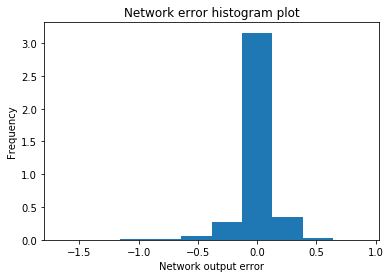

Error; maximal over inputs, average over dropout:
True values array mean: 0.100050 variance 0.221651
Experiment 0.496664 Std 0.530274
Equation   3.026134 Std 3.443143
Tightness  16.4% Std 15.4%


(0.4966644, 0.53027445, 3.0261336995015506, 3.4431429421598683, 0.2216512)

In [74]:
experiment.run(repetitions = 1000, inputs = 100)

In [7]:
#errors = [experiment.get_error(obj, repetitions = 100) for obj in tqdm(x)]

In [8]:
#np.max(np.mean(np.abs(errors), axis = 1))

In [57]:
def calculate_output(exp, x, p = 0.1):
    inp = x
    layers = []
    assert len(exp.W) == len(exp.B)
    for i, (w, b) in enumerate(zip(exp.W, exp.B)):
        if i >= 0:
            dead_neurons = np.where(np.random.rand(w.shape[0]) <= p)[0]
            w = np.copy(w)
            w[dead_neurons, :] = 0
        is_last = i == len(exp.W) - 1
        act = (lambda x : x) if is_last else (lambda x : exp.K * np.maximum(x, 0))
        layers.append(np.max(inp))
        plt.figure()
        plt.title('Activations for layer %d' % i)
        #print(inp)
        plt.hist(inp.reshape(-1))
        xx = np.abs(inp.reshape(-1))
        print(np.mean(xx), np.median(xx))
        plt.show()
        inp = act((inp @ w) + b).reshape(x.shape[0], -1)
    return inp, layers

0.7963218031579156 0.6714158724098459


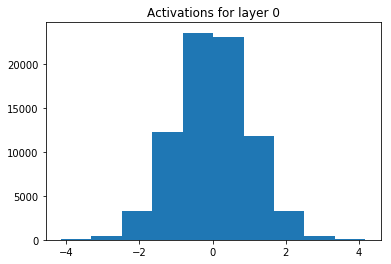

5.1460669829837205 1.4572189445525199


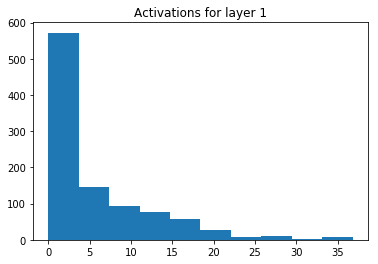

11.272123772897139 0.6773603267706271


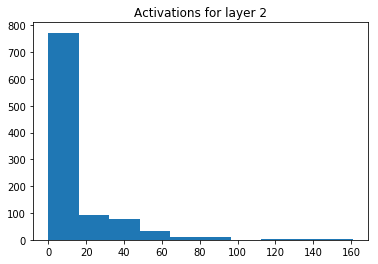

11.448617821620264 0.0


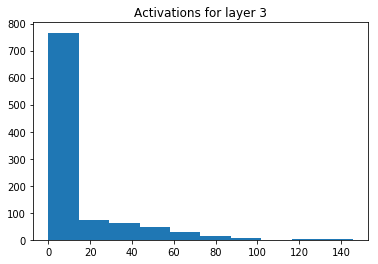

In [58]:
z = calculate_output(experiment, np.random.randn(100, 784), p = 0.5)

In [59]:
experiment.C

[5.843417, 12.915418, 17.976147]

0.13022236994797937 0.0


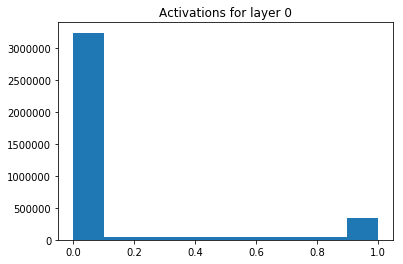

1.652505331294604 1.231355360427908


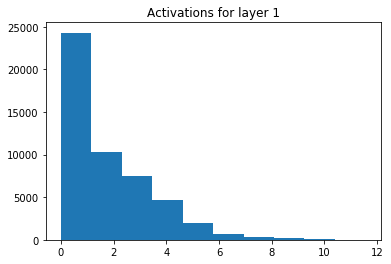

2.0718027665292333 0.8000847286990598


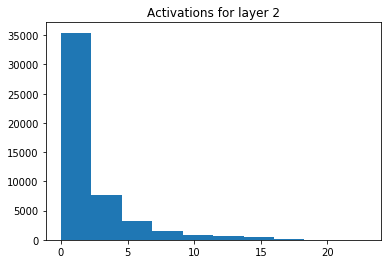

0.7466053837181209 0.43089654008470024


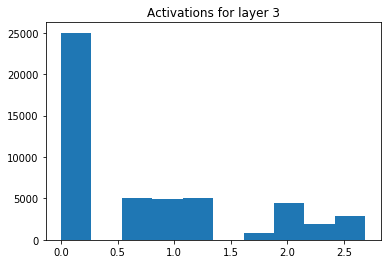

In [62]:
z = calculate_output(experiment, x[:5000, :], p = 0.9)

In [30]:
x[0].shape

(100, 10)

In [23]:
experiment.C

array([49.82485962, 55.65070724])